# How to Create Custom Automated Machine Learning Algorithms

Because there exist many different machine learning algorithms that each have their own hyperparameters to tune, an API has been developed to allow the data scientist to evolve the best set of parameters for a given algorithm.

In this example, we will evolve the hyperparameters for a `RandomForestRegressor` on the `Boston` dataset from `sklearn`.

Random Forests have many different hyperparameters for tuning, making it an excellent case study for designing your own automated machine learning algorithm using the framework in `EvolutionaryComputation`.

The main parameters we will focus on for Random Forests is `bootstrap`, `max_depth`, `max_features`, `min_samples_leaf`, `min_samples_split`, and `n_estimators`. Of course, there exist other parameters for Random Forests in `sklearn` but for now we will only focus on these parameters. For more information about these selected hyper-parameters, please checkout the `sklearn` [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor).

For our purposes, here are the possible values for each parameter:
- Bootstrap: *True or False*
- Max Depth: *10 to 100 and None*
- Max Features: *auto or sqrt*
- Min Samples Leaf: *1 to 4*
- Min Samples Split: *2 to 10*
- Number of Estimators: *200 to 2000*

To create the custom algorithm, we first need to create the bounds of the algorithm from the domain of the possible hyperparamters. The bounds will contain only continuous numbers, which will then be transformed into the parameter value based uppon its continuous value:

| Parameter | Min | Max | Comments |
| --- | --- | --- | --- |
| BootStrap | 0 | 1 | <= 0.5 is True, else is False |
| Max Depth | 10 | 110 | > 100 is None |
| Max Features | 0| 1 | <= 0.5 is auto, else is sqrt  |
| Min Leaf | 1 | 4 | Rounded to Integer |
| Min Split | 2 | 10 |Rounded to Integer |
| Num. Est | 200 | 2000 | Rounded to Integer |

From above, we obtain the following upper bound of our domain: `[1, 110, 1, 4, 10, 2000]`, while we obtain the following lower bound: `[0, 10, 0, 1, 2, 200]`

From the domain we can create a random set of parameters by uniformly sampling from the lower and upper bounds. For example, suppose we get the following set of values: `[0.434, 74.345, 0.752, 2.291, 7.453, 1692.983]`, which then corresponds to the following hyper-parameters: 
- Bootstrap: *True*
- Max Depth: *74*
- Max Features: *sqrt*
- Min Samples Leaf: *2*
- Min Samples Split: *7*
- Number of Estimators: *1693*


Unlike standard optimization problems, optimization problems based off training models for machine learning can take a long time. Therefore, certain steps must be taken in order to maximize the fitness of the final model. For example, suppose that it takes 5 minutes to train a single machine learning model, meaning that an initial population of 20 models and 100 generations using the `differential` algorithm will create $20*100=2000$ models, taking $10000$ minutes, or $2.77$ days to train. Therefore, we must reduce the population size and number of generations to meet a maximum limit of models created. 

If the maximum limit of allowable models created in our example is 300 then we must maximize the diversity and exploitative power of the algorithm. If we have too large of an initial population our algorithm will never converge in time, but if our initial population is too small it will converge to a sub-optimal model. It has been shown that the diversity of the initial population directly controls the results of the algorithm. Therefore, to maximize both diversity and convergence, we create a large initial population to explore the domain space and then reduce the population to only a handful of the best individuals for evolution. 

In our example of a limit of 300 models to be trained, we create an initial population of 100 models and select only the best 10 to be evolved for 20 generations. The large initial population allows for exploration while evolving only the best 10 allows for exploitation and convergence about the best models.

How to choose initial population size? If the domain space is extremely modal, with many local optima it is suggest to make the initial populaion size large as the purpose of the initial population is to find the best models while the evolution process is to optimize the final set of models from the initial population size. However, a usual 50/50 splitoff is usually sufficient where half the models limit is trained for the initial population and last half of the limit is trained during the evolution process. 

In [1]:
import EvolutionaryComputation.AutoML as ml

Best: 0.8340762982355445, Median: 0.8340762982355445, Worst: 0.8340762982355445
Best: 0.8340762982355445, Median: 0.7957122814765016, Worst: 0.7573482647174586
Best: 0.8340762982355445, Median: 0.7573482647174586, Worst: 0.7463846791664548
Best: 0.843583110549146, Median: 0.7957122814765016, Worst: 0.7463846791664548
Best: 0.855421485210662, Median: 0.8340762982355445, Worst: 0.7463846791664548

GENERATION 0:
  Best Fit: 0.855421485210662, Mean Fit: 0.8443602979984508
GENERATION 1:
  Best Fit: 0.855421485210662, Mean Fit: 0.8443602979984508

GENERATION 0:
  Best Fit: 0.8674404556703051, Mean Fit: 0.8624281133248438
GENERATION 1:
  Best Fit: 0.8706775646674665, Mean Fit: 0.866676552312105


In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import time

# Introduction to the Data Set

In [3]:
boston = load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

# Data Preprocessing
For preprocessing, we will only scale the target and feature variables to be between 0 and 1.

In [4]:
# number of observations
n = len(boston.data)

# create indices
ind = np.asarray(range(0, n))

# shuffle
np.random.shuffle(ind)

x = pd.DataFrame(boston.data, columns = boston.feature_names)
y = np.asarray(boston['target'])

# convert to numpy array
x = np.asarray(x)
x = x[ind]
# scale between 0 and 1
mx = np.max(x, axis=0)
mn = np.min(x, axis=0)
x = (x-mn)/(mx-mn)

# scale between 0 and 1
mx = np.max(y, axis=0)
mn = np.min(y, axis=0)
y = (y-mn)/(mx-mn)
y = y[ind]

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Fitness Function
As with all otpimization problems, we need to define the fitness function. The fitness function takes in the population of individuals, creates the model from each indivdual, and records the cross-validation score.

Because the dataset size is relatively small, we can perform k-fold cross-validation and sum the score to obtain the fitness of the model. In this example, the score is based off the Total Sum of Squared Errors (TSS).

It must be stressed that the fitness function MUST take in two parameters, the population and init_pop_print (for printing out the results during the initial population perod). 

In [37]:
def create_model(individual):
    # create model
    if individual[0] <= 0.5:
        bootstrap = True
    else:
        bootstrap = False

    if individual[1] > 100:
        max_depth = None
    else:
        max_depth = int(np.round(individual[1], 0))

    if individual[2] <= 0.5:
        max_features = 'auto'
    else:
        max_features = 'sqrt'

    min_samples_leaf = np.maximum(1, int(np.round(individual[3], 0)))
    min_samples_split = np.maximum(2, int(np.round(individual[4], 0)))
    n_estimators = int(np.round(individual[5], 0))

    forest = RandomForestRegressor(bootstrap=bootstrap, max_depth=max_depth, max_features=max_features,
                                   min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,
                                   n_estimators=n_estimators)
    return forest

In [38]:
def fitness_function(population, init_pop_print=False):
    fits = []
    index = 0
    for individual in population:  # for each individual in population
        
       
        forest = create_model(individual)
        # test model using 3 splits
        kf = KFold(n_splits=3)
        loc_fit = []
        for train, test, in kf.split(x):
            forest.fit(x[train], y[train])
            loc_fit.append(r2_score(y[test], forest.predict(x[test])))

        # sum up TSS from each split
        fits.append(np.mean(loc_fit))
        
        if init_pop_print:
            if index % 50 == 0:
                print("Individual: {}".format(index))
            msg = 'Best: {}, Median: {}, Worst: {}'.format(np.max(fits), np.median(fits), np.min(fits))
            print(msg)
        index = index + 1
            
    return np.asarray(fits)

In [39]:
upper_bound = [1, 110, 1, 4, 10, 2000]
lower_bound = [0, 10, 0, 1, 2, 200]

init_size = 500
gen_size = 20

# Running Initial Population

In [24]:
init_pop = ml.CustomInitialPopulation(upper_bound=upper_bound, lower_bound=lower_bound, init_size=init_size)
start = time.time()
init_pop.fit(fitness_function=fitness_function)
finish = time.time()
print("Time Taken: {}".format(finish-start))

Individual: 0
Best: 0.8739144570867419, Median: 0.8739144570867419, Worst: 0.8739144570867419
Best: 0.8739144570867419, Median: 0.8319830089763987, Worst: 0.7900515608660553
Best: 0.8739144570867419, Median: 0.8438067623090545, Worst: 0.7900515608660553
Best: 0.8739144570867419, Median: 0.8392095681827172, Worst: 0.7900515608660553
Best: 0.8816689287425515, Median: 0.8438067623090545, Worst: 0.7900515608660553
Best: 0.8816689287425515, Median: 0.8468018099072031, Worst: 0.7900515608660553
Best: 0.8816689287425515, Median: 0.8438067623090545, Worst: 0.7900515608660553
Best: 0.8926313223215739, Median: 0.8468018099072031, Worst: 0.7900515608660553
Best: 0.8926313223215739, Median: 0.8438067623090545, Worst: 0.7900515608660553
Best: 0.8926313223215739, Median: 0.8392095681827172, Worst: 0.7900515608660553
Best: 0.8926313223215739, Median: 0.8438067623090545, Worst: 0.7900515608660553
Best: 0.8926313223215739, Median: 0.84596423475722, Worst: 0.7900515608660553
Best: 0.8926313223215739, Me

Best: 0.8926313223215739, Median: 0.8531261510611435, Worst: 0.7673972381467862
Best: 0.8926313223215739, Median: 0.854912385961747, Worst: 0.7673972381467862
Best: 0.8926313223215739, Median: 0.8531261510611435, Worst: 0.7673972381467862
Best: 0.8926313223215739, Median: 0.8513399161605401, Worst: 0.7673972381467862
Best: 0.8926313223215739, Median: 0.8531261510611435, Worst: 0.7673972381467862
Best: 0.8926313223215739, Median: 0.854912385961747, Worst: 0.7673972381467862
Best: 0.8926313223215739, Median: 0.8531261510611435, Worst: 0.7673972381467862
Best: 0.8926313223215739, Median: 0.854912385961747, Worst: 0.7673972381467862
Best: 0.8926313223215739, Median: 0.8531261510611435, Worst: 0.7673972381467862
Best: 0.8926313223215739, Median: 0.854912385961747, Worst: 0.7673972381467862
Best: 0.8926313223215739, Median: 0.8551992221849332, Worst: 0.7673972381467862
Best: 0.8926313223215739, Median: 0.8554860584081192, Worst: 0.7673972381467862
Best: 0.8926313223215739, Median: 0.85519922

Best: 0.8926313223215739, Median: 0.8497968575053517, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8495739323525205, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8493510071996894, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8493034565018815, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8492559058040737, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8489492495588364, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8492559058040737, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8493034565018815, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8492559058040737, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8489492495588364, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8492559058040737, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8489492495588364, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8492

Best: 0.8926313223215739, Median: 0.8489492495588364, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8492559058040737, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8489492495588364, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.848642593313599, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8486082084965672, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.848642593313599, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8489492495588364, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.848642593313599, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8486082084965672, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8485738236795353, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8486082084965672, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8485738236795353, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8485045

Best: 0.8926313223215739, Median: 0.8482747762928614, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8482578016688674, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8482408270448735, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8482354099092457, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8482299927736179, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8482004129814893, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8481708331893606, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8481462701973731, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8481217072053856, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8480931909289176, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8481217072053856, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8481462701973731, Worst: 0.7673605133868572
Best: 0.8926313223215739, Median: 0.8481

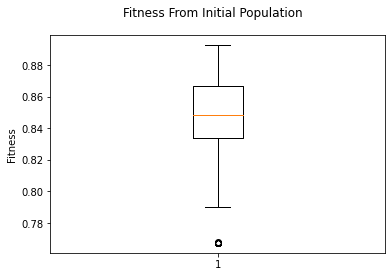

In [25]:
init_pop.plot()

# Running Evolutionary Algorithms

There are two main ways that the Custom Automated Machine Learning class works. One works by taking the best individuals from the initial population, while the second takes only the best and creates a population through randomly changing the best individual

## Create Generation from Best Individuals

This algorithm works by taking taking the best `gen_size` individuals, from the initial population, to form the generation. 

In [26]:
algorithm = ml.CustomAutoMLAlgorithm(fitness_function=fitness_function, gen_size=gen_size, custom_initial_population=init_pop)

start = time.time()
algorithm.evolve(max_iter=38, find_max=True, algorithm='differential')
finish = time.time()
print("Time Taken: {}".format(finish-start))

GENERATION 0:
  Best Fit: 0.8926313223215739, Mean Fit: 0.8851866025691141
GENERATION 1:
  Best Fit: 0.8926313223215739, Mean Fit: 0.8864624626487754
GENERATION 2:
  Best Fit: 0.8926313223215739, Mean Fit: 0.8868022697353861
GENERATION 3:
  Best Fit: 0.8926313223215739, Mean Fit: 0.8876147946563222
GENERATION 4:
  Best Fit: 0.8926313223215739, Mean Fit: 0.8883520712723106
GENERATION 5:
  Best Fit: 0.8926313223215739, Mean Fit: 0.8890636409483497
GENERATION 6:
  Best Fit: 0.8926313223215739, Mean Fit: 0.8893661357285415
GENERATION 7:
  Best Fit: 0.8939918196322073, Mean Fit: 0.8900381830618059
GENERATION 8:
  Best Fit: 0.8939918196322073, Mean Fit: 0.8902698469393269
GENERATION 9:
  Best Fit: 0.8939918196322073, Mean Fit: 0.8904693853484579
GENERATION 10:
  Best Fit: 0.8939918196322073, Mean Fit: 0.8905481581244011
GENERATION 11:
  Best Fit: 0.8939918196322073, Mean Fit: 0.8906189883173319
GENERATION 12:
  Best Fit: 0.8939918196322073, Mean Fit: 0.8908266899112591
GENERATION 13:
  Best 

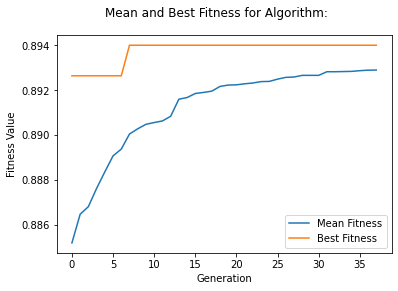

In [27]:
algorithm.plot()

As we can see from the results above, the best model achieved an $R^2$ values of 0.89399 extremely early, around generation 8. However, the mean fitness still increased, instead of stalling out. In this way, if we were to evolve for further generations the best might increase. Lets evolve for 12 more iterations.

### Evolving for 12 more Generations

In [42]:
start = time.time()
algorithm.evolve(max_iter=12, find_max=True, algorithm='differential', warm_start=True)
finish = time.time()
print("Time Taken: {}".format(finish-start))

GENERATION 0:
  Best Fit: 0.8933631147534579, Mean Fit: 0.8901822758688633
GENERATION 1:
  Best Fit: 0.8933631147534579, Mean Fit: 0.8908072154346266
GENERATION 2:
  Best Fit: 0.8933631147534579, Mean Fit: 0.8914619985470568
GENERATION 3:
  Best Fit: 0.8933631147534579, Mean Fit: 0.891726128040364
GENERATION 4:
  Best Fit: 0.8933631147534579, Mean Fit: 0.8918767762746045
GENERATION 5:
  Best Fit: 0.8935102782516361, Mean Fit: 0.892027354891084
GENERATION 6:
  Best Fit: 0.8935102782516361, Mean Fit: 0.8921848008239074
GENERATION 7:
  Best Fit: 0.8936393337621894, Mean Fit: 0.8924103296073366
GENERATION 8:
  Best Fit: 0.8936393337621894, Mean Fit: 0.8924640702460339
GENERATION 9:
  Best Fit: 0.8936393337621894, Mean Fit: 0.8925860531109112
GENERATION 10:
  Best Fit: 0.8940592144573726, Mean Fit: 0.8928374317748979
GENERATION 11:
  Best Fit: 0.8940592144573726, Mean Fit: 0.8928417817679175
Time Taken: 1062.2493543624878


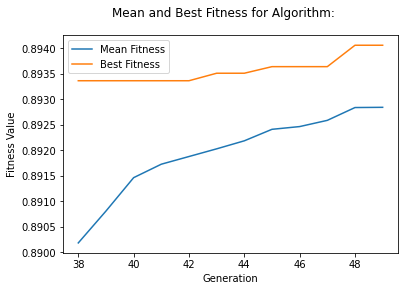

In [45]:
algorithm.plot(starting_gen=38)

As we can see above, evolving for 12 more generations increased the best model to an $R^2$ value of $0.89405$. If we were to evolve for furthur generations we might increase this value again for the best model.

## Create Generation around Best Individual

This algorithm works by taking taking the best individual and creating a population of size `gen_size`, by randomly changing the best individual by some variation of the total bounds.

To use this algorithm, include the `best_sigma` parameter in the initializer. It is set to `None` by defualt. The current value for this example is $0.2$, which means that the populaion is created by altering the best individual by $20$% of the the total bounds.

In [40]:
algorithm2 = ml.CustomAutoMLAlgorithm(fitness_function=fitness_function, gen_size=gen_size, 
                                     custom_initial_population=init_pop, best_sigma=0.2)

start = time.time()
algorithm2.evolve(max_iter=38, find_max=True, algorithm='differential')
finish = time.time()
print("Time Taken: {}".format(finish-start))

GENERATION 0:
  Best Fit: 0.8919325928540096, Mean Fit: 0.8854758027898096
GENERATION 1:
  Best Fit: 0.8922336847282092, Mean Fit: 0.8883109127924926
GENERATION 2:
  Best Fit: 0.8936242059329748, Mean Fit: 0.8901844380439641
GENERATION 3:
  Best Fit: 0.8936242059329748, Mean Fit: 0.8909847501385384
GENERATION 4:
  Best Fit: 0.8936242059329748, Mean Fit: 0.8917961211585717
GENERATION 5:
  Best Fit: 0.8936242059329748, Mean Fit: 0.891926746535332
GENERATION 6:
  Best Fit: 0.8936242059329748, Mean Fit: 0.892003807963321
GENERATION 7:
  Best Fit: 0.8936242059329748, Mean Fit: 0.8920578525493752
GENERATION 8:
  Best Fit: 0.8936242059329748, Mean Fit: 0.8921593200214138
GENERATION 9:
  Best Fit: 0.8936242059329748, Mean Fit: 0.8922787673052204
GENERATION 10:
  Best Fit: 0.8936242059329748, Mean Fit: 0.8923338514431588
GENERATION 11:
  Best Fit: 0.8936242059329748, Mean Fit: 0.8923619239524205
GENERATION 12:
  Best Fit: 0.8936242059329748, Mean Fit: 0.8923723943283699
GENERATION 13:
  Best Fi

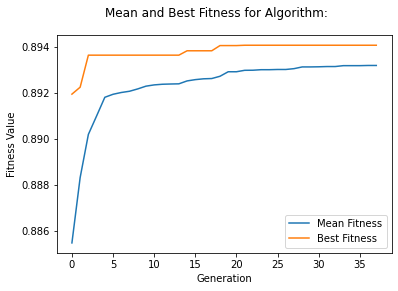

In [41]:
algorithm2.plot()

As we can see above, this method acheived a best score of $0.89405$ for $R^2$.

## Choosing the Best Method

Here in this example two methods for creating the generation population for evolution have been shown, creating the population from the best `gen_size` individuals from the initial population, or creating a population of `gen_size` individuals by randomly changing the single best individual from the initial population by a variation of `best_sigma` percent.

Choosing between the two methods when computation is limited may be difficult. The first method is suggested when the best `gen_size` individuals are not very similar, because if they are similar then there may not be much advancement towards the best model as all the best individuals have already 'converged'. In response, the second method creates some variance and diversity in the population by created random individuals that are slightly different from the best and then evolving from there. 

In general, the first method is used as default as it may be difficult to determine whether or not the best handful of individuals are similar. However, if the first method is not achieving acceptable results, then the second method is for sure going to include some variance into the evolution process. 
